# 仲景基礎對話功能

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import gradio as gr

# Set the device
device = "cuda"  # replace with your device: "cpu", "cuda", "mps"

# Initialize model and tokenizer
peft_model_id = "CMLM/ZhongJing-2-1_8b"
base_model_id = "Qwen/Qwen1.5-1.8B-Chat"
model = AutoModelForCausalLM.from_pretrained(base_model_id, device_map="auto")
model.load_adapter(peft_model_id)
tokenizer = AutoTokenizer.from_pretrained(
    "CMLM/ZhongJing-2-1_8b", padding_side="right", trust_remote_code=True, pad_token=""
)


def get_model_response(question):
    # Create the prompt without context
    prompt = f"Question: {question}"
    messages = [
        {"role": "system", "content": "You are a helpful medical assistant."},
        {"role": "user", "content": prompt},
    ]

    # Prepare the input
    text = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(device)

    # Generate the response
    generated_ids = model.generate(model_inputs.input_ids, max_new_tokens=512)
    generated_ids = [
        output_ids[len(input_ids) :]
        for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Decode the response
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return response


# Define a Gradio interface without the context parameter
def chat_interface(question):
    response = get_model_response(question)
    return response


iface = gr.Interface(
    fn=chat_interface,
    inputs=["text"],
    outputs="text",
    title="仲景GPT-V2-1.8B",
    description="博极医源，精勤不倦。Unlocking the Wisdom of Traditional Chinese Medicine with AI.",
)

# Launch the interface with sharing enabled
# iface.launch(share=True)
iface.launch()

# LIME 手動中文空格分詞版本

In [ ]:
from lime.lime_text import LimeTextExplainer
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import numpy as np

# 加載模型和分詞器
peft_model_id = "CMLM/ZhongJing-2-1_8b"
base_model_id = "Qwen/Qwen1.5-1.8B-Chat"
model = AutoModelForCausalLM.from_pretrained(base_model_id, device_map="auto")
model.load_adapter(peft_model_id)
tokenizer = AutoTokenizer.from_pretrained(
    "CMLM/ZhongJing-2-1_8b", padding_side="right", trust_remote_code=True, pad_token=""
)


def predictor(texts):
    results = []
    for text in texts:
        # 創建消息格式
        messages = [
            {"role": "system", "content": "You are a helpful medical assistant."},
            {"role": "user", "content": text},
        ]

        # 準備輸入
        formatted_text = tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        inputs = tokenizer([formatted_text], return_tensors="pt").to(model.device)

        with torch.no_grad():
            # 獲取模型輸出
            outputs = model(**inputs)
            logits = outputs.logits

            # 計算最後一個token的概率分布
            probs = torch.softmax(logits[0, -1], dim=-1)

            # 取前兩個最高概率
            top_probs = torch.topk(probs, 2)
            prob_array = np.array(
                [top_probs.values[0].item(), top_probs.values[1].item()]
            )

            # 標準化概率
            prob_array = prob_array / prob_array.sum()
            results.append(prob_array)

    return np.array(results)


# 創建解釋器
explainer = LimeTextExplainer(
    class_names=["中医相关", "非中医相关"],
    split_expression=lambda x: x.split(),  # 使用空格分詞
    bow=True,
    random_state=42,
)

# 測試文本（使用中文）
test_text = "喉咙痛 的 中医 疗法"

# 生成解釋
explanation = explainer.explain_instance(
    text_instance=test_text,
    classifier_fn=predictor,
    num_features=10,
    num_samples=1000,
    top_labels=1,
)

# 顯示解釋結果
print("\n=== 詞語重要性分析 ===")
for word, importance in explanation.as_list(label=0):
    print(f"詞語: {word:<20} 影響度: {importance:.4f}")

# 生成HTML可視化
html = explanation.as_html()
with open("zhongjing_explanation.html", "w", encoding="utf-8") as f:
    f.write(html)

# LIME - jieba 中文自動分词版本

In [3]:
from lime.lime_text import LimeTextExplainer
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import numpy as np
import jieba

device = "cuda"

# 加載模型和分詞器
peft_model_id = "CMLM/ZhongJing-2-1_8b"
base_model_id = "Qwen/Qwen1.5-1.8B-Chat"
model = AutoModelForCausalLM.from_pretrained(base_model_id, device_map="auto")
model.load_adapter(peft_model_id)
tokenizer = AutoTokenizer.from_pretrained(
    "CMLM/ZhongJing-2-1_8b", padding_side="right", trust_remote_code=True, pad_token=""
)


def get_model_response(question):
    # Create the prompt without context
    prompt = f"Question: {question}"
    messages = [
        {"role": "system", "content": "You are a helpful medical assistant."},
        {"role": "user", "content": prompt},
    ]

    # Prepare the input
    text = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(device)

    # Generate the response
    generated_ids = model.generate(model_inputs.input_ids, max_new_tokens=512)
    generated_ids = [
        output_ids[len(input_ids) :]
        for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Decode the response
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return response


def predictor(texts):
    results = []
    for text in texts:
        # 創建消息格式
        messages = [
            {"role": "system", "content": "You are a helpful medical assistant."},
            {"role": "user", "content": text},
        ]

        # 準備輸入
        formatted_text = tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        inputs = tokenizer([formatted_text], return_tensors="pt").to(model.device)

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits[0, -1], dim=-1)
            top_probs = torch.topk(probs, 2)
            prob_array = np.array(
                [top_probs.values[0].item(), top_probs.values[1].item()]
            )
            prob_array = prob_array / prob_array.sum()
            results.append(prob_array)

    return np.array(results)


# 自定義分詞函數
def chinese_tokenizer(text):
    return list(jieba.cut(text, cut_all=False))


# 創建解釋器
explainer = LimeTextExplainer(
    class_names=["症状诊断相关", "症状诊断不相关"],
    split_expression=chinese_tokenizer,  # 使用jieba分詞
    bow=True,
    random_state=42,
)

In [5]:
import textwrap


# 基本用法
def wrap_text(text, width=70):
    # 使用textwrap.fill()直接返回換行後的文本字符串
    wrapped_text = textwrap.fill(text, width=width)
    return wrapped_text


# 更多自定義選項的用法
def wrap_text_advanced(text, width=70, initial_indent="", subsequent_indent="  "):
    wrapper = textwrap.TextWrapper(
        width=width,  # 每行最大寬度
        initial_indent=initial_indent,  # 第一行縮進
        subsequent_indent=subsequent_indent,  # 後續行縮進
        break_long_words=True,  # 允許斷開長單詞
        break_on_hyphens=True,  # 允許在連字符處斷行
    )
    wrapped_text = wrapper.fill(text)
    return wrapped_text


# 示例文本
text = "这是一段很长的中文文本，需要进行自动换行处理。通过使用Python的textwrap模块，我们可以轻松实现文本的自动换行功能，使得输出的文本更加整齐美观。"

# 基本換行
print("基本換行示例：")
print(wrap_text(text, width=20))

print("\n高級換行示例：")
print(wrap_text_advanced(text, width=20, initial_indent="    ", subsequent_indent="  "))

基本換行示例：
这是一段很长的中文文本，需要进行自动换行
处理。通过使用Python的textwr
ap模块，我们可以轻松实现文本的自动换行
功能，使得输出的文本更加整齐美观。

高級換行示例：
    这是一段很长的中文文本，需要进行
  自动换行处理。通过使用Python的
  textwrap模块，我们可以轻松实
  现文本的自动换行功能，使得输出的文本
  更加整齐美观。


In [43]:
print("\n=== 病人提問 ===")
# 測試文本
test_text = "张某，男，27岁。患者因昨晚饮酒发热，喝凉水数杯，早晨腹痛腹泻，大便如水色黄，腹中辘辘有声，恶心欲吐，胸中满闷不舒，口干欲冷饮，舌质红、苔白腻，脉沉细数。给出中医诊断和处方建议。"
print(wrap_text((test_text), width=30))


# 模型結果
print("\n=== 模型結果 ===")
response = get_model_response(test_text)
print(wrap_text(response, width=30))

# 生成解釋
explanation = explainer.explain_instance(
    text_instance=test_text,
    classifier_fn=predictor,
    num_features=len(chinese_tokenizer(test_text)),
    num_samples=1500,
    top_labels=1,
)

# 顯示解釋結果
print("\n=== 詞語重要性分析 ===")
for word, importance in explanation.as_list(label=0):
    print(f"詞語: {word:<20} 影響度: {importance:.4f}")


=== 病人提問 ===
张某，男，27岁。患者因昨晚饮酒发热，喝凉水数杯，早晨腹痛腹
泻，大便如水色黄，腹中辘辘有声，恶心欲吐，胸中满闷不舒，口干
欲冷饮，舌质红、苔白腻，脉沉细数。给出中医诊断和处方建议。

=== 模型結果 ===
中医诊断：寒湿内盛证。 处方建议： 1、方剂选择：藿香正气散
加减。若腹泻频繁，可适当增加麻黄9克、杏仁6克；若腹部疼痛较
剧，则可以加入附子3克，甘草5克。 2、其他：（1）服用本药
后要禁食生冷油腻食物，尤其是冷饮。（2）平时注意防寒保暖，避
免受凉，防止加重病情。

=== 詞語重要性分析 ===
詞語: 中医                   影響度: -0.1029
詞語: 昨晚                   影響度: -0.0220
詞語: 给出                   影響度: 0.0188
詞語: 苔白腻                  影響度: 0.0187
詞語: 处方                   影響度: -0.0179
詞語: 恶心                   影響度: -0.0176
詞語: 张某                   影響度: 0.0158
詞語: 发热                   影響度: -0.0136
詞語: 舌质                   影響度: 0.0135
詞語: 饮酒                   影響度: 0.0134
詞語: 冷饮                   影響度: 0.0113
詞語: 诊断                   影響度: 0.0113
詞語: 欲                    影響度: 0.0112
詞語: 胸中                   影響度: 0.0112
詞語: 如                    影響度: -0.0106
詞語: ，                    影響度: 0.0097
詞語: 腹中                   影響度: 0.0094
詞語: 岁                    影響度: 0.0091
詞語: 。                    影響度: -0.0088
詞語: 吐            

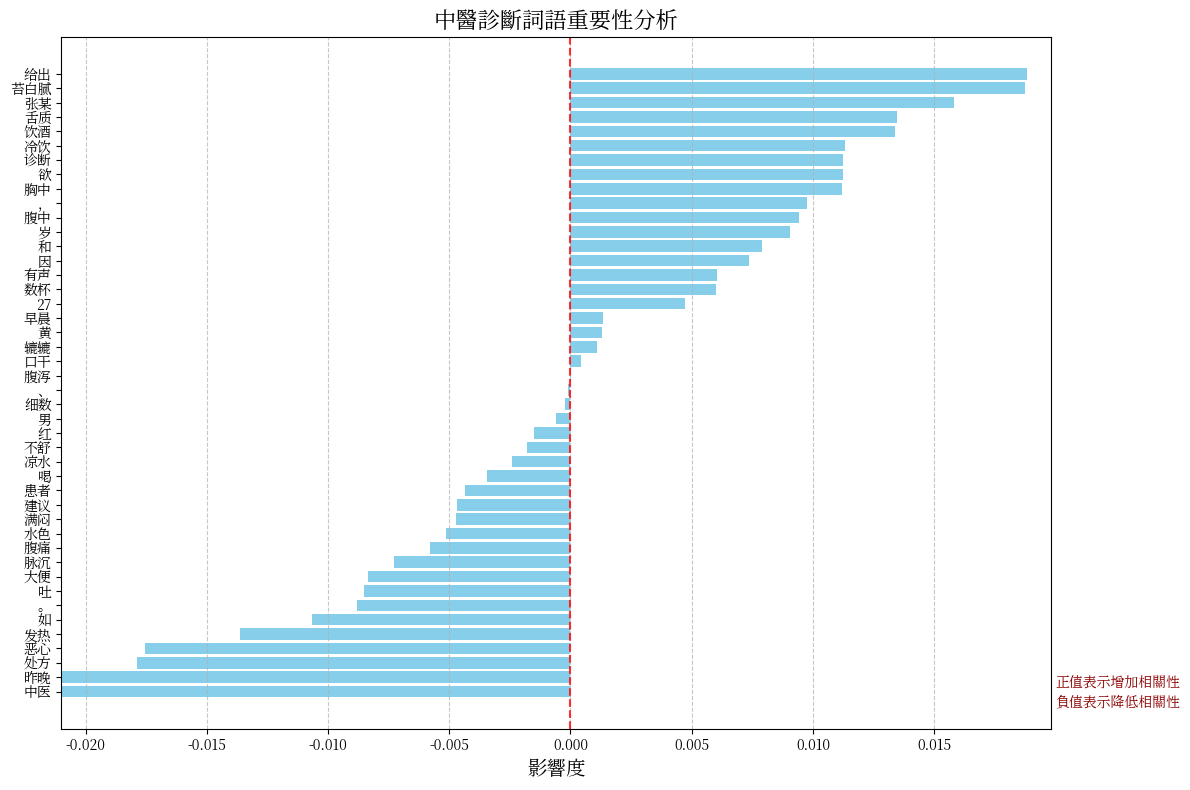

In [49]:
import matplotlib.pyplot as plt
import pandas as pd

# 設置全局字體為黑體
plt.rcParams["font.family"] = ["Noto Serif CJK JP"]
plt.rcParams["axes.unicode_minus"] = False

# 從explanation獲取結果並創建數據框
words_importance = explanation.as_list(label=0)
df = pd.DataFrame(words_importance, columns=["詞語", "影響度"])

# 按影響度排序
df = df.sort_values("影響度", ascending=True)

# 創建水平條形圖
plt.figure(figsize=(12, 8))
plt.barh(df["詞語"], df["影響度"], color="skyblue")

# 設置標題和標籤
plt.title("中醫診斷詞語重要性分析", fontsize=16)
plt.xlabel("影響度", fontsize=14)

# 添加參考線
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.axvline(x=0, color="red", linestyle="--", alpha=0.8)

# 添加註釋
plt.text(
    0.02, -1, "正值表示增加相關性\n負值表示降低相關性", fontsize=10, color="darkred"
)

# 調整布局
plt.xlim(-0.02 - 0.001, max(df["影響度"]) + 0.001)  # 右側留些空間

plt.tight_layout()

# 保存圖片
# plt.savefig("lime_analysis.png", dpi=300, bbox_inches="tight")

# 顯示圖表
plt.show()